## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [1]:
!pip install -q transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 11.0 MB/s eta 0:00:00


## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [2]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [3]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [4]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [5]:
from transformers import SegformerImageProcessor

root_dir = '/content/ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [7]:
encoded_inputs = train_dataset[0]

In [8]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [9]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [10]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [11]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [13]:
batch = next(iter(train_dataloader))

In [14]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [15]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [16]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False,  True,  ...,  True, False, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]],

        [[False,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [False, False,  True,  ...,  True, False, False],
         [False, False,  True,  ...,  True, False, False],
         [False, False, False,  ..., False, False, False]]])

In [17]:
batch["labels"][mask]

tensor([0, 0, 0,  ..., 3, 3, 3])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [18]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ade20k-id2label.json:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [19]:
import evaluate

metric = evaluate.load("mean_iou")

In [20]:
image_processor.do_reduce_labels

True

In [21]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.1419196128845215
Mean_iou: 7.263369023390261e-05
Mean accuracy: 0.0005293768312094066
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 5.0574049949646
Mean_iou: 0.00062117722986556
Mean accuracy: 0.004375140615505317
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.956119060516357
Mean_iou: 0.003632002586787751
Mean accuracy: 0.051788058094369614
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.6627936363220215
Mean_iou: 0.009595410758554673
Mean accuracy: 0.06738480707700681
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.581512928009033
Mean_iou: 0.015501530437923405
Mean accuracy: 0.17458370330955458
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.293152809143066
Mean_iou: 0.026922367357948528
Mean accuracy: 0.1684011488253469
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.033849239349365
Mean_iou: 0.0611132099049979
Mean accuracy: 0.3560292030111951
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.899362087249756
Mean_iou: 0.0560206030278112
Mean accuracy: 0.36167691904674987
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.8554818630218506
Mean_iou: 0.06564328594723319
Mean accuracy: 0.2253049008689304
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.375711441040039
Mean_iou: 0.14223214741402
Mean accuracy: 0.6048493422341943
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.665341377258301
Mean_iou: 0.11843078556436457
Mean accuracy: 0.2774984793897613
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.6440672874450684
Mean_iou: 0.0753837836872899
Mean accuracy: 0.4554985357771024
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.445528745651245
Mean_iou: 0.12955695969988776
Mean accuracy: 0.3495634013202828
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.794968605041504
Mean_iou: 0.07114420318453568
Mean accuracy: 0.44690165517943187
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.2574617862701416
Mean_iou: 0.3554491754484032
Mean accuracy: 0.6052107608911902
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.3503193855285645
Mean_iou: 0.25739552543777955
Mean accuracy: 0.37457266789323856
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.184123992919922
Mean_iou: 0.0846837404299871
Mean accuracy: 0.16009378139194613
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6998178958892822
Mean_iou: 0.42252550218952706
Mean accuracy: 0.4900558311496557
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.383321762084961
Mean_iou: 0.12893286318695643
Mean accuracy: 0.34039845288799914
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.949408531188965
Mean_iou: 0.10946483073203912
Mean accuracy: 0.2133425304405859
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.9406580924987793
Mean_iou: 0.2735977218146629
Mean accuracy: 0.37041078190933346
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.006105661392212
Mean_iou: 0.10172259513860188
Mean accuracy: 0.15235856730496383
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.8131048679351807
Mean_iou: 0.25936209278717864
Mean accuracy: 0.3888861926138123
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0986862182617188
Mean_iou: 0.3680817410716178
Mean accuracy: 0.5364067378187372
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.141629457473755
Mean_iou: 0.29972597130166
Mean accuracy: 0.5400388153880067
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3231866359710693
Mean_iou: 0.18446446147833784
Mean accuracy: 0.30346017098834643
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.521103620529175
Mean_iou: 0.10871362576082642
Mean accuracy: 0.17534921397897898
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.183927536010742
Mean_iou: 0.4095049367699195
Mean accuracy: 0.5912567655759876
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3171417713165283
Mean_iou: 0.23854087622075962
Mean accuracy: 0.4186012075208011
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.677578330039978
Mean_iou: 0.26842543365735927
Mean accuracy: 0.3461692395303212
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1154820919036865
Mean_iou: 0.21155690970188334
Mean accuracy: 0.3380767557783921
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1527974605560303
Mean_iou: 0.16283659056236294
Mean accuracy: 0.23804781627340676
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9729201793670654
Mean_iou: 0.2381934444804394
Mean accuracy: 0.45108298460356283
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.20351505279541
Mean_iou: 0.5015083576177466
Mean accuracy: 0.6291979318809885
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4196857213974
Mean_iou: 0.4660676212503558
Mean accuracy: 0.6311557313850201
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.036155939102173
Mean_iou: 0.1263083496182346
Mean accuracy: 0.2156643261676102
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1279540061950684
Mean_iou: 0.36930879322134685
Mean accuracy: 0.5110888454387503
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7660992741584778
Mean_iou: 0.42801188719822875
Mean accuracy: 0.613112027217402
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.079868793487549
Mean_iou: 0.17759012747097344
Mean accuracy: 0.2283721397567437
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.178717851638794
Mean_iou: 0.5091252001981135
Mean accuracy: 0.6054702708366178
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6817426681518555
Mean_iou: 0.27622570206082314
Mean accuracy: 0.3687376062176284
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9683258533477783
Mean_iou: 0.16740606614414458
Mean accuracy: 0.22668302490217881
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9813284873962402
Mean_iou: 0.38925111542463714
Mean accuracy: 0.5149894097530407
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6386427879333496
Mean_iou: 0.3470295725382424
Mean accuracy: 0.5450003861453575
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7996388673782349
Mean_iou: 0.5047288129697691
Mean accuracy: 0.6154898419438717
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3812432289123535
Mean_iou: 0.3364170474228785
Mean accuracy: 0.5642558169397227
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1874051094055176
Mean_iou: 0.37995976793502134
Mean accuracy: 0.5444584612365825
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5328859090805054
Mean_iou: 0.4976951995136846
Mean accuracy: 0.6538531542000404
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3954615592956543
Mean_iou: 0.29294286465496333
Mean accuracy: 0.39558644836851353
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5735214948654175
Mean_iou: 0.21492164306960707
Mean accuracy: 0.3625934024725962
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.710240364074707
Mean_iou: 0.17908683110787257
Mean accuracy: 0.23197910734629243
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3956114053726196
Mean_iou: 0.7007329459500399
Mean accuracy: 0.7760396502029753
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6689105033874512
Mean_iou: 0.29046625632230433
Mean accuracy: 0.3789116854536195
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0672396421432495
Mean_iou: 0.21980698528479362
Mean accuracy: 0.2876390873278846
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2677719593048096
Mean_iou: 0.19583212994731697
Mean accuracy: 0.3595215130971891
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9735073447227478
Mean_iou: 0.41066307917235423
Mean accuracy: 0.5290201620834963
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4076280891895294
Mean_iou: 0.3996166426647503
Mean accuracy: 0.6171748095172527
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.697529911994934
Mean_iou: 0.3566609253799658
Mean accuracy: 0.5458761638871079
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1345211267471313
Mean_iou: 0.27987499639413055
Mean accuracy: 0.40609345102160194
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.057552456855774
Mean_iou: 0.44973702163686813
Mean accuracy: 0.6156225900751607
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.534908652305603
Mean_iou: 0.20372492178711493
Mean accuracy: 0.31932807863656376
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2109301090240479
Mean_iou: 0.12206724499112181
Mean accuracy: 0.20284898182856834
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3424915075302124
Mean_iou: 0.21171852538030264
Mean accuracy: 0.3410586488652503
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1784517765045166
Mean_iou: 0.2785506210168495
Mean accuracy: 0.3282402842337051
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1438384056091309
Mean_iou: 0.3770130868036676
Mean accuracy: 0.4617352646631958
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.064566969871521
Mean_iou: 0.22288373521212893
Mean accuracy: 0.29557691971777533
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3313398361206055
Mean_iou: 0.13874703423061582
Mean accuracy: 0.21421284884133773
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0909324884414673
Mean_iou: 0.37937398939887657
Mean accuracy: 0.4662375060459522
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1102616786956787
Mean_iou: 0.42568269690819516
Mean accuracy: 0.5558168658936089
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.904400110244751
Mean_iou: 0.4613442839101777
Mean accuracy: 0.6187097422162182
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9648091793060303
Mean_iou: 0.2158703898261296
Mean accuracy: 0.35937923048257125
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1176822185516357
Mean_iou: 0.6663470814764751
Mean accuracy: 0.7959627152721721
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1161065101623535
Mean_iou: 0.6123929555889822
Mean accuracy: 0.7835513750512139
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2006781101226807
Mean_iou: 0.41676240115977486
Mean accuracy: 0.7291880906554691
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1365829706192017
Mean_iou: 0.4184078788290937
Mean accuracy: 0.5740854362536801
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0063343048095703
Mean_iou: 0.26065411351755413
Mean accuracy: 0.39917366549862787
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2418750524520874
Mean_iou: 0.4313711793530892
Mean accuracy: 0.5312210873943277
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8761692047119141
Mean_iou: 0.21413763811858527
Mean accuracy: 0.2940651070368846
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0311508178710938
Mean_iou: 0.22285818970386598
Mean accuracy: 0.30585457897945867
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8853754997253418
Mean_iou: 0.23457160274182454
Mean accuracy: 0.2994977214096383
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9542814493179321
Mean_iou: 0.5757497567355562
Mean accuracy: 0.6620470685434382
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0025169849395752
Mean_iou: 0.37293112954513424
Mean accuracy: 0.47944790520789515
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1927192211151123
Mean_iou: 0.35381371484056057
Mean accuracy: 0.5708870173203952
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8345013856887817
Mean_iou: 0.22222542234273074
Mean accuracy: 0.3950561214838543
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6517971754074097
Mean_iou: 0.35521990722079777
Mean accuracy: 0.6333770354782599
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.111777424812317
Mean_iou: 0.4239893445248102
Mean accuracy: 0.5801594846326552
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.126550316810608
Mean_iou: 0.20210816700569947
Mean accuracy: 0.2730780763470152
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6054245829582214
Mean_iou: 0.4625777676131898
Mean accuracy: 0.6103871139827669
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8626243472099304
Mean_iou: 0.29519073834981624
Mean accuracy: 0.36403231160408056
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5878462195396423
Mean_iou: 0.40400219373694957
Mean accuracy: 0.6194289950450681
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.949810802936554
Mean_iou: 0.30246254782867504
Mean accuracy: 0.3942157958685119
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7832462787628174
Mean_iou: 0.24677964748729816
Mean accuracy: 0.4393861097202783
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5285155177116394
Mean_iou: 0.45279024178109323
Mean accuracy: 0.6573877699662408
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6533459424972534
Mean_iou: 0.38425175245581367
Mean accuracy: 0.5301653313945044
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38590142130851746
Mean_iou: 0.6201478611693026
Mean accuracy: 0.8246568256722884
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49885109066963196
Mean_iou: 0.42113101868369174
Mean accuracy: 0.6830761607658544
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9013712406158447
Mean_iou: 0.5337684140696237
Mean accuracy: 0.6460034064258912
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7861731648445129
Mean_iou: 0.5440633825165673
Mean accuracy: 0.6306392382104118
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9016520380973816
Mean_iou: 0.3523026542225765
Mean accuracy: 0.5100399453788245
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7513208389282227
Mean_iou: 0.5197254900669959
Mean accuracy: 0.6704583604073115
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8276379108428955
Mean_iou: 0.5222138486861108
Mean accuracy: 0.6303660488552614
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5875691175460815
Mean_iou: 0.55780197129523
Mean accuracy: 0.7288613500365533
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9437239170074463
Mean_iou: 0.2828208431137412
Mean accuracy: 0.35884620767709247
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8508254289627075
Mean_iou: 0.4835601076156615
Mean accuracy: 0.5691458044784787
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19173003733158112
Mean_iou: 0.41504413787575895
Mean accuracy: 0.634720795312272
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5829753279685974
Mean_iou: 0.4295015995895698
Mean accuracy: 0.5273300241000524
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0553220510482788
Mean_iou: 0.41986691518507735
Mean accuracy: 0.6043448616740837
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9112746119499207
Mean_iou: 0.2368911412911525
Mean accuracy: 0.29547047339763366
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6655563116073608
Mean_iou: 0.681124386098427
Mean accuracy: 0.7299640350343151
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.851368248462677
Mean_iou: 0.39711211910846084
Mean accuracy: 0.45241523917342064
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6845842599868774
Mean_iou: 0.30091727696415643
Mean accuracy: 0.38947385553839925
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16122235357761383
Mean_iou: 0.343887683797139
Mean accuracy: 0.6983539756597865
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24221710860729218
Mean_iou: 0.862131207995047
Mean accuracy: 0.905446376715112
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.518060564994812
Mean_iou: 0.7765656560154274
Mean accuracy: 0.8299870923159509
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5736850500106812
Mean_iou: 0.7897801341404079
Mean accuracy: 0.8354756383736746
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7925808429718018
Mean_iou: 0.2935153105259959
Mean accuracy: 0.3629509459415548
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3667618930339813
Mean_iou: 0.43806293448636496
Mean accuracy: 0.7056380490005559
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5134629607200623
Mean_iou: 0.29667998518947664
Mean accuracy: 0.5488590896758411
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7495924234390259
Mean_iou: 0.3054806876742688
Mean accuracy: 0.39065591951629297
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6410850286483765
Mean_iou: 0.4770024545958859
Mean accuracy: 0.5243516205812088
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6094677448272705
Mean_iou: 0.31015476016729876
Mean accuracy: 0.3863891328471567
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5778709053993225
Mean_iou: 0.5755369552960333
Mean accuracy: 0.6920179798407939
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6101438403129578
Mean_iou: 0.2085749070660391
Mean accuracy: 0.3188132651627078
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12473693490028381
Mean_iou: 0.4375023072288086
Mean accuracy: 0.7205633691723324
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5765119791030884
Mean_iou: 0.4402487126794144
Mean accuracy: 0.4864452576332429
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5740169882774353
Mean_iou: 0.4978458152325904
Mean accuracy: 0.6165970287237357
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.44143757224082947
Mean_iou: 0.5748995426267771
Mean accuracy: 0.6793335144885414
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5590453147888184
Mean_iou: 0.6229133534358516
Mean accuracy: 0.7060377239347103
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2870265245437622
Mean_iou: 0.5468665820122347
Mean accuracy: 0.6172999797684505
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6309718489646912
Mean_iou: 0.2702264905171467
Mean accuracy: 0.3742510272343983
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6061663627624512
Mean_iou: 0.401700084751826
Mean accuracy: 0.47645205175496286
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6478899717330933
Mean_iou: 0.5528385470204555
Mean accuracy: 0.6180513954016424
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.657867431640625
Mean_iou: 0.506774199415032
Mean accuracy: 0.6373487590759984
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5315300226211548
Mean_iou: 0.5101386838252466
Mean accuracy: 0.5581782090611561
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5618235468864441
Mean_iou: 0.2651713597660123
Mean accuracy: 0.3544406780082893
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2893756628036499
Mean_iou: 0.46049846071239037
Mean accuracy: 0.7590858832829991
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4488362669944763
Mean_iou: 0.33689561002920415
Mean accuracy: 0.5251645375878989
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6712384819984436
Mean_iou: 0.423893970281098
Mean accuracy: 0.48962312233260297
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5247312784194946
Mean_iou: 0.2054412517048948
Mean accuracy: 0.3325636066820545
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5226973295211792
Mean_iou: 0.4715239107320872
Mean accuracy: 0.5398307575275885
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6746934056282043
Mean_iou: 0.411919813537663
Mean accuracy: 0.4767356145984859
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5808329582214355
Mean_iou: 0.4936391301701195
Mean accuracy: 0.5409994380610276
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6473901867866516
Mean_iou: 0.6351346151337776
Mean accuracy: 0.8876299768283674
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17291125655174255
Mean_iou: 0.9153101580223963
Mean accuracy: 0.9369839301963796
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2996274530887604
Mean_iou: 0.4629205551261372
Mean accuracy: 0.7657419799967324
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4843303859233856
Mean_iou: 0.6027925785424788
Mean accuracy: 0.6787970201268964
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.424609899520874
Mean_iou: 0.39530135534898014
Mean accuracy: 0.5638488839970208
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6134089827537537
Mean_iou: 0.5593717760286807
Mean accuracy: 0.6370538053057186
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16410677134990692
Mean_iou: 0.9162008703372603
Mean accuracy: 0.9442266608351682
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5211473703384399
Mean_iou: 0.6673438716765495
Mean accuracy: 0.6943371589233385
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20209001004695892
Mean_iou: 0.8423952299902197
Mean accuracy: 0.8576457095635076
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22563333809375763
Mean_iou: 0.5299912406328374
Mean accuracy: 0.624325424914928
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5541024208068848
Mean_iou: 0.34309094625369163
Mean accuracy: 0.41326142362949353
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4823589622974396
Mean_iou: 0.5464913237530811
Mean accuracy: 0.5942849514076031
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4155060350894928
Mean_iou: 0.5585628114783167
Mean accuracy: 0.6035504032869666
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23151341080665588
Mean_iou: 0.5023715216322305
Mean accuracy: 0.7755728222862025
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38375264406204224
Mean_iou: 0.6430108587669618
Mean accuracy: 0.7231041004215688
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6340691447257996
Mean_iou: 0.317377411106812
Mean accuracy: 0.3755110239519204
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.434444397687912
Mean_iou: 0.5636706329351123
Mean accuracy: 0.6122428621199314
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4184072017669678
Mean_iou: 0.6337212434546333
Mean accuracy: 0.7054346678967673
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4328225553035736
Mean_iou: 0.4945429296590305
Mean accuracy: 0.5635809713347302
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4670759439468384
Mean_iou: 0.2988285528543303
Mean accuracy: 0.37666321126546753
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37504905462265015
Mean_iou: 0.38513171229584114
Mean accuracy: 0.5729957671378253
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28373387455940247
Mean_iou: 0.46894616078563917
Mean accuracy: 0.612740170866931
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42985278367996216
Mean_iou: 0.6099048064973843
Mean accuracy: 0.6606353250414221
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3863472640514374
Mean_iou: 0.5532580396255199
Mean accuracy: 0.6408300066617328
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12521439790725708
Mean_iou: 0.8333058868450349
Mean accuracy: 0.8562805189731408
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42694634199142456
Mean_iou: 0.3758252477410853
Mean accuracy: 0.4325528152175727
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.416377454996109
Mean_iou: 0.21182463043668484
Mean accuracy: 0.355090558012868
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6440240740776062
Mean_iou: 0.33372591095777915
Mean accuracy: 0.40777685292562343
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.48995450139045715
Mean_iou: 0.5334921301865729
Mean accuracy: 0.6563545843834985
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3600192368030548
Mean_iou: 0.5790293500195051
Mean accuracy: 0.6912358961928573
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3293195068836212
Mean_iou: 0.32450801691627756
Mean accuracy: 0.5555745499729207
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3982839286327362
Mean_iou: 0.6142842041778748
Mean accuracy: 0.6571509135299022
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3622552752494812
Mean_iou: 0.5268423082922815
Mean accuracy: 0.7490925971585926
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27038323879241943
Mean_iou: 0.49740868582378905
Mean accuracy: 0.7694203265787147
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.378335177898407
Mean_iou: 0.37801735667474995
Mean accuracy: 0.457112400316127
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28739896416664124
Mean_iou: 0.31368087259162014
Mean accuracy: 0.561230731982519
Epoch: 178


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1902010291814804
Mean_iou: 0.4149864105171491
Mean accuracy: 0.7700929616112382
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3546588122844696
Mean_iou: 0.6160405490634997
Mean accuracy: 0.7279205341361065
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3948719799518585
Mean_iou: 0.2114448919260857
Mean accuracy: 0.3306036140690274
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4252786636352539
Mean_iou: 0.30978059692904886
Mean accuracy: 0.40379952174826217
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.37407544255256653
Mean_iou: 0.6198339043700507
Mean accuracy: 0.6927268627447046
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3981689512729645
Mean_iou: 0.35795645781010244
Mean accuracy: 0.48347695179865574
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36575081944465637
Mean_iou: 0.5855214240351231
Mean accuracy: 0.6928122543872507
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3729446232318878
Mean_iou: 0.3850213064586473
Mean accuracy: 0.4444056722325293
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3287911117076874
Mean_iou: 0.6057070169439396
Mean accuracy: 0.6518132437900742
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4483291506767273
Mean_iou: 0.5441418985464408
Mean accuracy: 0.6528156331150395
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.26857414841651917
Mean_iou: 0.8756631665569199
Mean accuracy: 0.9380217881796842
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.32902657985687256
Mean_iou: 0.38144253237668124
Mean accuracy: 0.45521620593162215
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23489560186862946
Mean_iou: 0.8385613467257996
Mean accuracy: 0.8723682064541406
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.14914573729038239
Mean_iou: 0.4490391562441602
Mean accuracy: 0.7664847652695632
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.23994407057762146
Mean_iou: 0.9270678655868494
Mean accuracy: 0.9598726349792676
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3523011803627014
Mean_iou: 0.414919058336322
Mean accuracy: 0.49617200464084155
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.279701828956604
Mean_iou: 0.5702350368901684
Mean accuracy: 0.6622416724164771
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3536590039730072
Mean_iou: 0.6756760462276731
Mean accuracy: 0.7220003965280279
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.204279825091362
Mean_iou: 0.8605336709328877
Mean accuracy: 0.8876512067165181
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27864784002304077
Mean_iou: 0.7714750992309701
Mean accuracy: 0.8077367064448324
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.28826919198036194
Mean_iou: 0.6304665300300311
Mean accuracy: 0.6734528711855154
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3192739486694336
Mean_iou: 0.38901914215998623
Mean accuracy: 0.49444313216519875


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

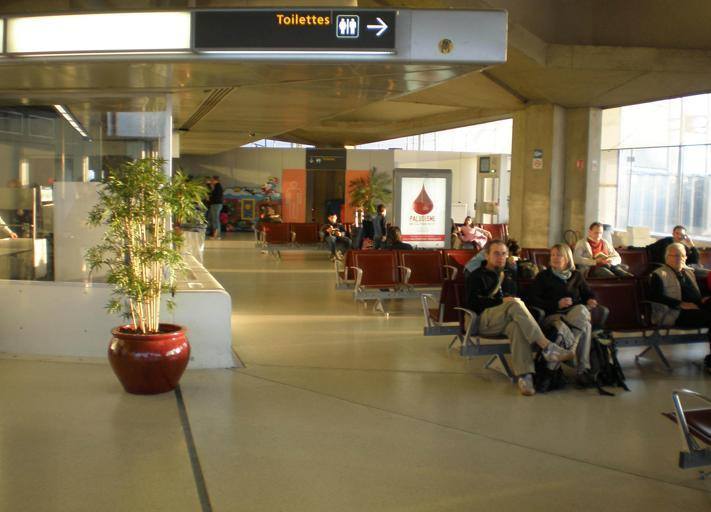

In [22]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000002.jpg')
image

In [23]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [24]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [25]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [26]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [27]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


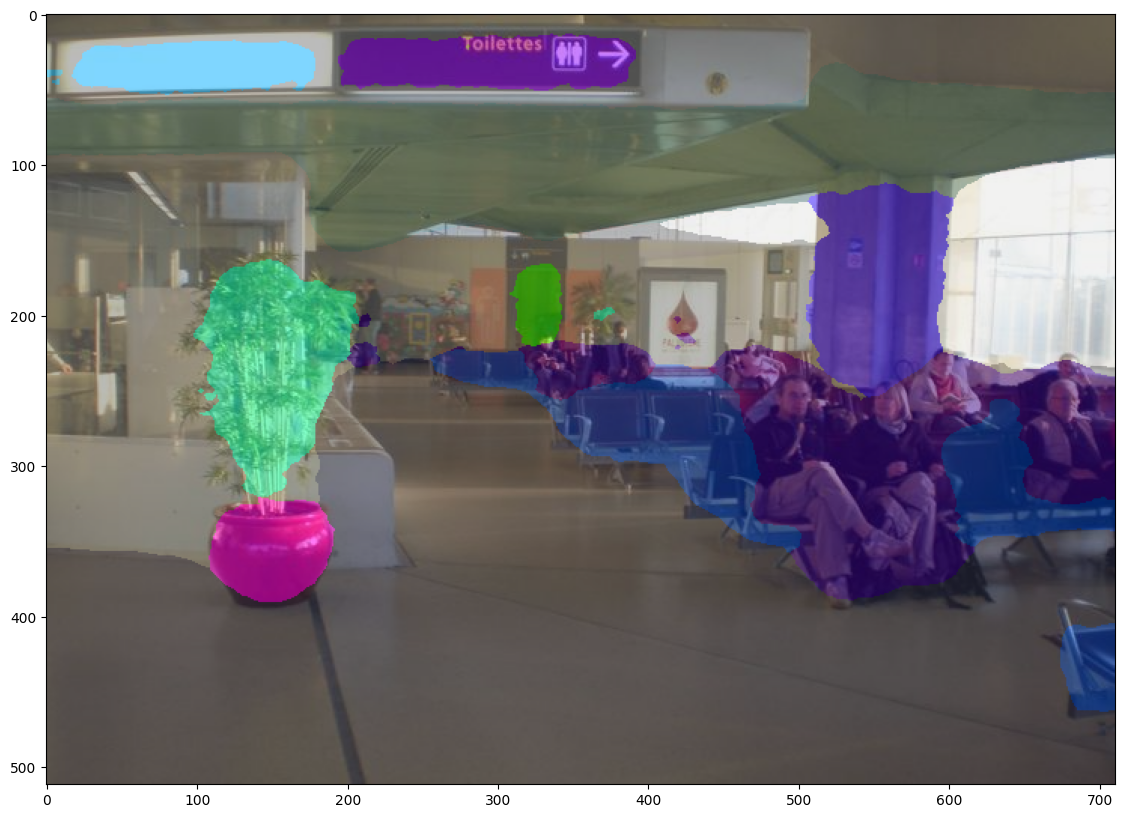

In [28]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

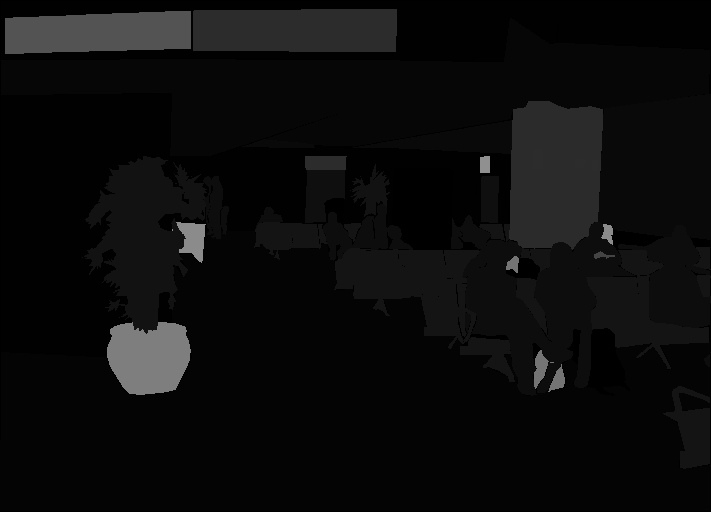

In [29]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000002.png')
map

Classes in this image: ['wall', 'floor', 'ceiling', 'windowpane', 'person', 'door', 'plant', 'chair', 'column', 'signboard', 'book', 'light', 'bag', 'pot', 'ashcan', 'monitor', None]


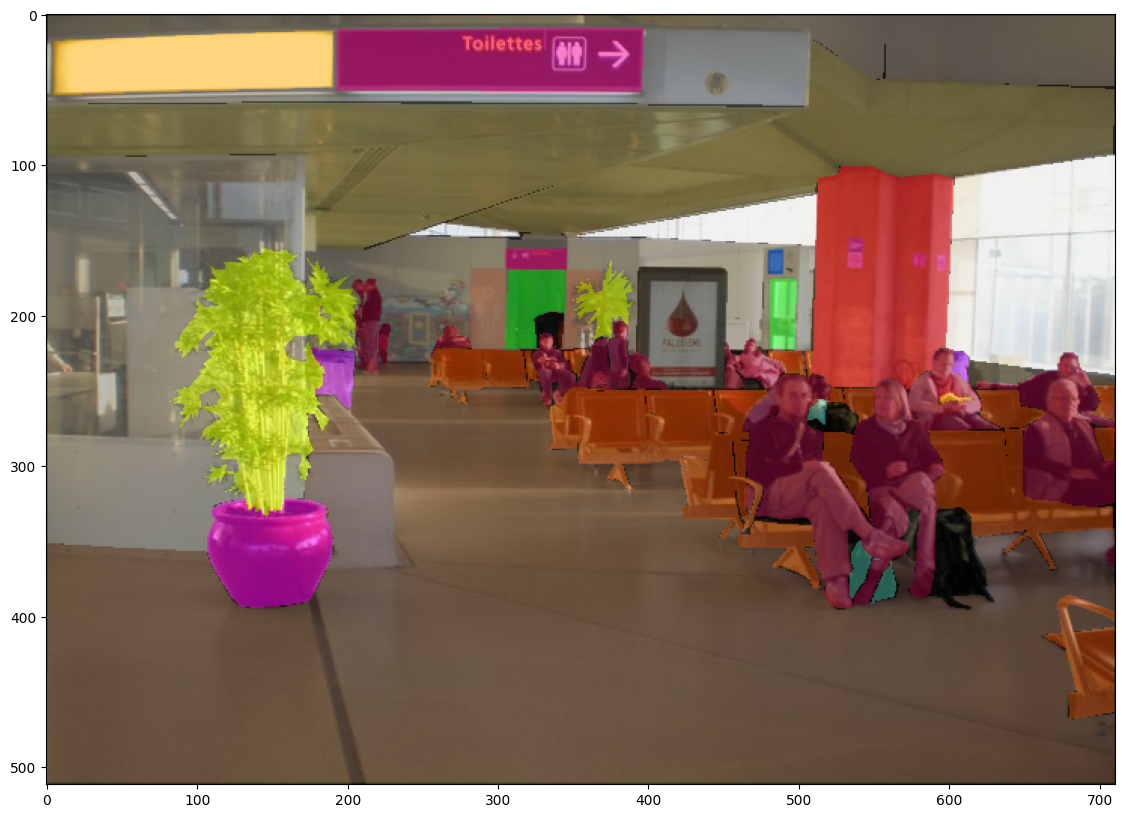

In [30]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [31]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

In [32]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [33]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.5689171275873941
mean_accuracy 0.6092999831661914
overall_accuracy 0.9185538293983982
---------------------
per-category metrics:


IoU  accuracy
wall      0.812239  0.975966
building       NaN       NaN
sky            NaN       NaN
floor     0.962824  0.986075
tree           NaN       NaN
...            ...       ...
shower         NaN       NaN
radiator       NaN       NaN
glass          NaN       NaN
clock          NaN       NaN
flag           NaN       NaN

[150 rows x 2 columns]

In [34]:
metric_table

{'wall': [0.8122390208783298, 0.9759656281088251],
 'building': [nan, nan],
 'sky': [nan, nan],
 'floor': [0.9628241491085899, 0.986074535152821],
 'tree': [nan, nan],
 'ceiling': [0.9279139803189684, 0.9689084748765419],
 'road': [nan, nan],
 'bed ': [nan, nan],
 'windowpane': [0.8874055276659127, 0.9177316293929713],
 'grass': [nan, nan],
 'cabinet': [nan, nan],
 'sidewalk': [nan, nan],
 'person': [0.7147737898295332, 0.8829409151488228],
 'earth': [nan, nan],
 'door': [0.4358565737051793, 0.4588926174496644],
 'table': [nan, nan],
 'mountain': [nan, nan],
 'plant': [0.7015751995972093, 0.7684550539667533],
 'curtain': [nan, nan],
 'chair': [0.6757390050468637, 0.7218638682969096],
 'car': [nan, nan],
 'water': [nan, nan],
 'painting': [nan, nan],
 'sofa': [nan, nan],
 'shelf': [nan, nan],
 'house': [nan, nan],
 'sea': [nan, nan],
 'mirror': [nan, nan],
 'rug': [nan, nan],
 'field': [nan, nan],
 'armchair': [nan, nan],
 'seat': [nan, nan],
 'fence': [nan, nan],
 'desk': [nan, nan],
 